# Problem Set 6
In this problem set you will implement SGD and SVRG and compare the two to each other, and also to GD.

# Problem 1: Stochastic Variance Reduced Gradient Descent (SVRG)

As we discussed in the video lectures, decomposable functions of the form
$$
\min_{\omega} \left [ F(\omega) = \frac{1}{n} \sum_i^n f_i(\omega) \right ],
$$
are very common in statistics/ML problems. Here, each $f_i$ corresponds to a loss for a particular training example. For
example, if $f_i(\omega) = (\omega^\top x_i - y_i)^2$, then $F(\omega)$ is a least
squares regression problem. The standard gradient descent (GD) update
$$
\omega_t = \omega_{t-1} - \eta_t \nabla F(\omega_{t-1})
$$

evaluates the full gradient $\nabla F(\omega) = \frac{1}{n} \sum_i^n \nabla
f_i(\omega)$, which requires evaluating $n$ derivatives. This can be
prohibitively expensive when the number of training examples $n$ is large. SGD evaluates
the gradient of one (or a small subset) of the training examples--drawn
randomly from ${1,...n}$--per iteration:
$$
\omega_t = \omega_{t-1} - \eta_t \nabla f_i(\omega_{t-1}).
$$

In expectation, the updates are equivalent, but SGD has the computational
advantage of only evaluating a single gradient $\nabla f_i(\omega)$. The
disadvatage is that the randomness introduces variance, which slows
convergence. This was our motivation in class to introduce the SVRG algorithm.

Given the dataset in **digits.zip**, plot the performance of GD, SGD, and SVRG for logistic regression with $l2$ regularization in terms of negative log likelihood on the training data against the number of gradient evaluations for a single training example (GD performs $n$ such evaluations per iteration and SGD performs $1$). Choose the $l2$ parameter to optimize performance on the test set. How does the choice of $T$ (the number of inner loops) affect the performance of SVRG? There should be one plot with a title and three lines with different colors, markers, and legend labels.



In [ ]:
import zipfile as zipfile
import pandas as pd
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import time
import pdb

%matplotlib inline

#sample code to load digits.zip
def loaddata(filename):
    data={}
    with zipfile.ZipFile(filename) as z:
        for filename in z.namelist():
          data[filename] = pd.read_csv(z.open(filename), sep=' ', header=None)
    return data

digits_dict = loaddata('./digits.zip')
print(digits_dict.keys())
X_digits_train = digits_dict['X_digits_train.csv']
X_digits_test = digits_dict['X_digits_test.csv']
y_digits_train = digits_dict['y_digits_train.csv'].to_numpy(dtype=int).ravel()
y_digits_test = digits_dict['y_digits_test.csv'].to_numpy(dtype=int).ravel()

dict_keys(['X_digits_test.csv', 'X_digits_train.csv', 'y_digits_test.csv', 'y_digits_train.csv'])


The logistic regression model with L2 is:

min F(ω)= −1/N ∑[yi log(σ(ωT xi))+(1-yi)log(1-σ(ωT xi))]+ λ/2||w||

σ is the sigmoid, lambda is the L2 regularization parameter.


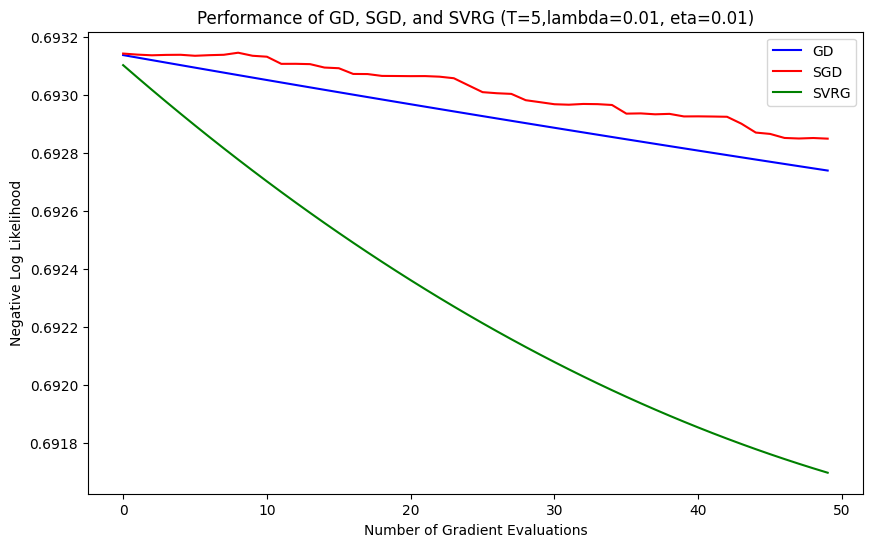

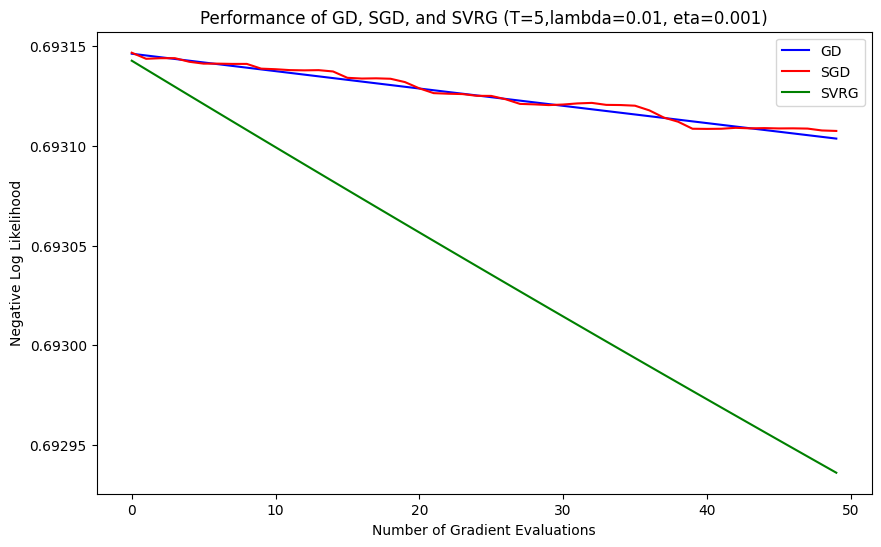

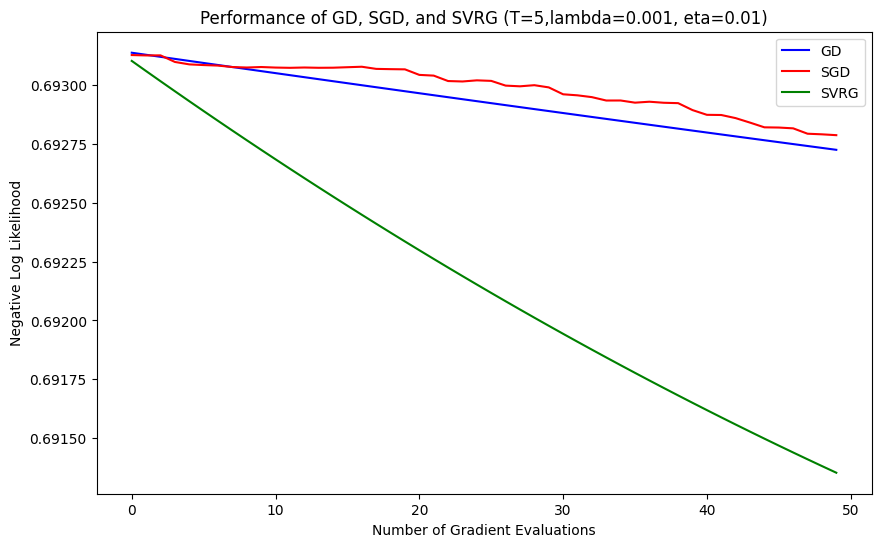

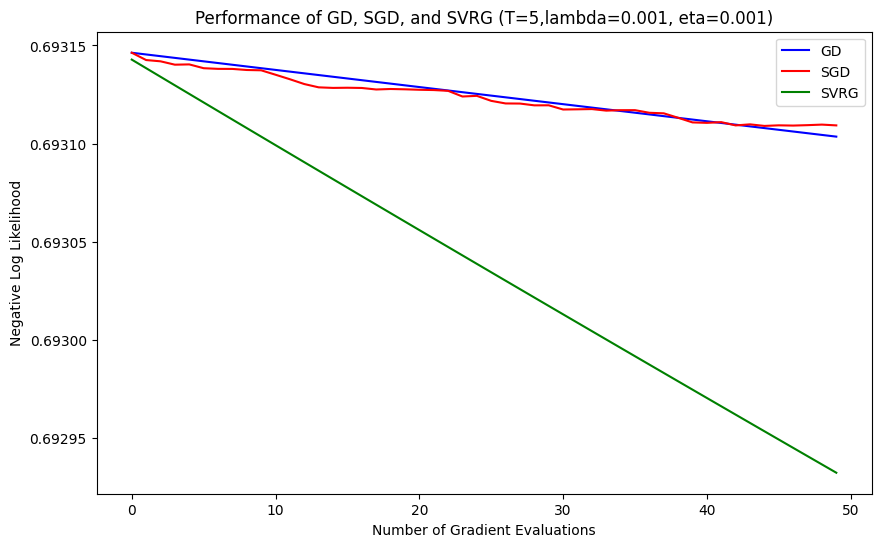

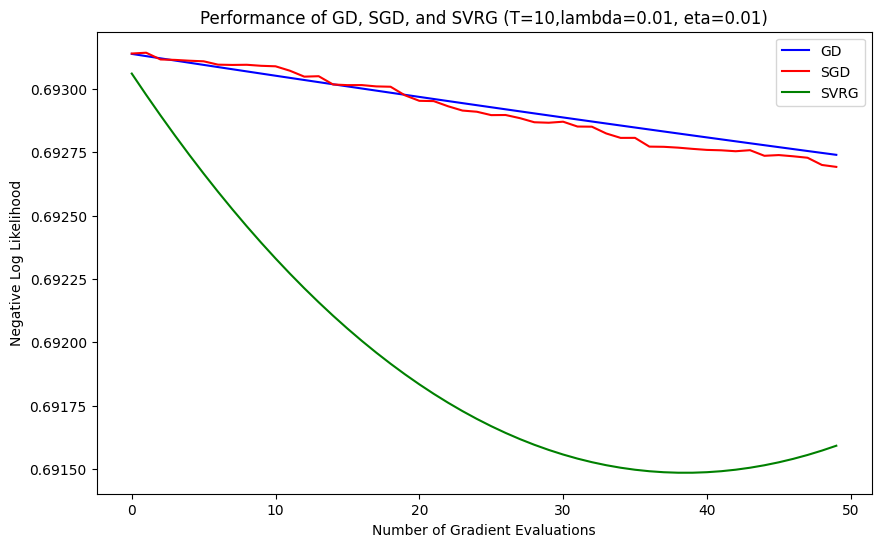

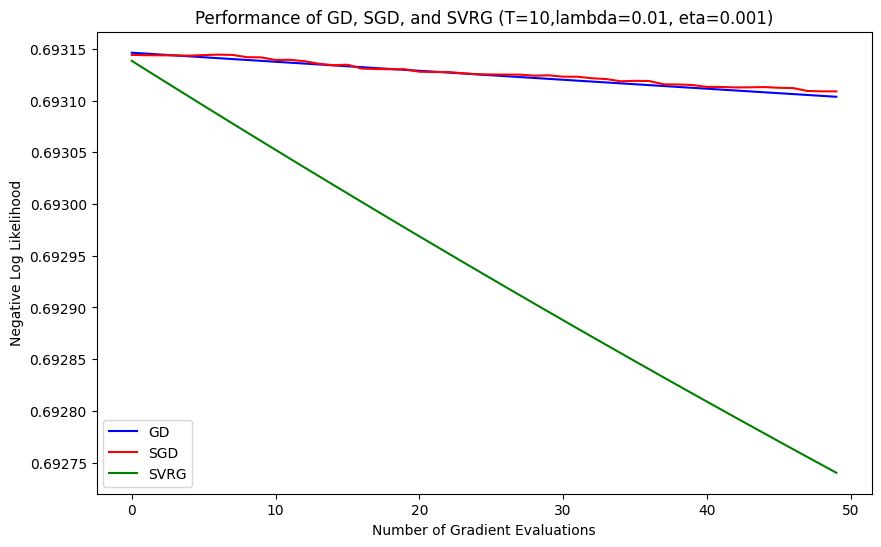

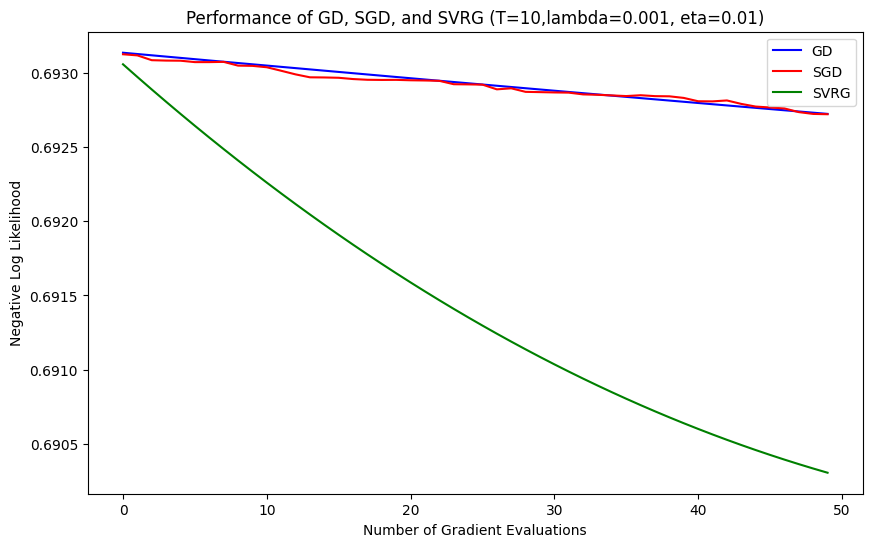

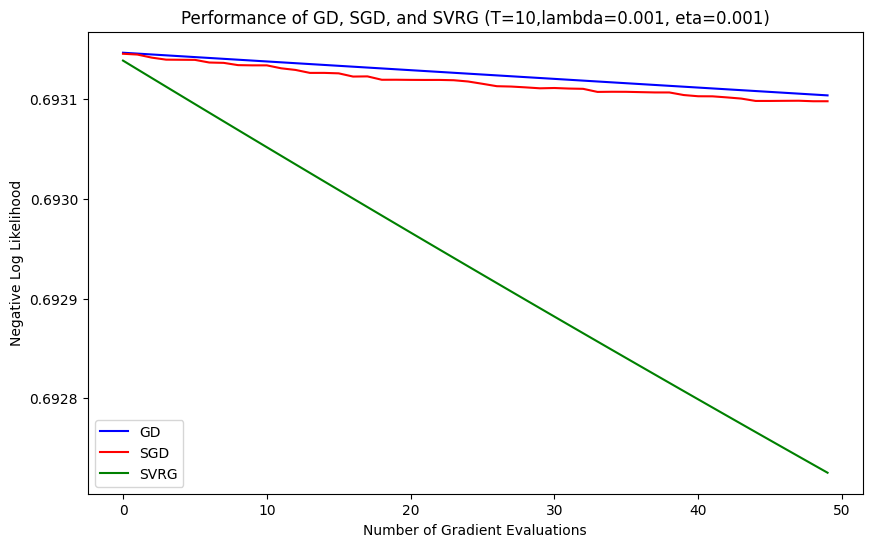

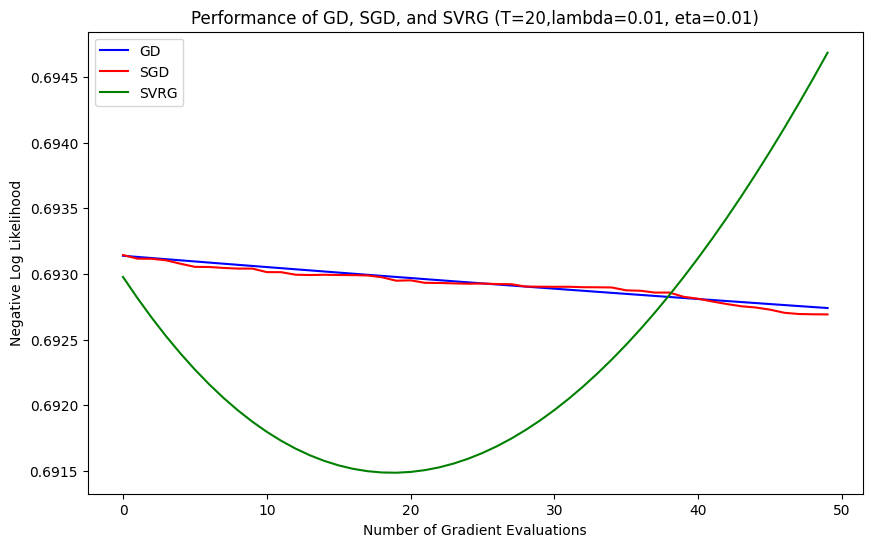

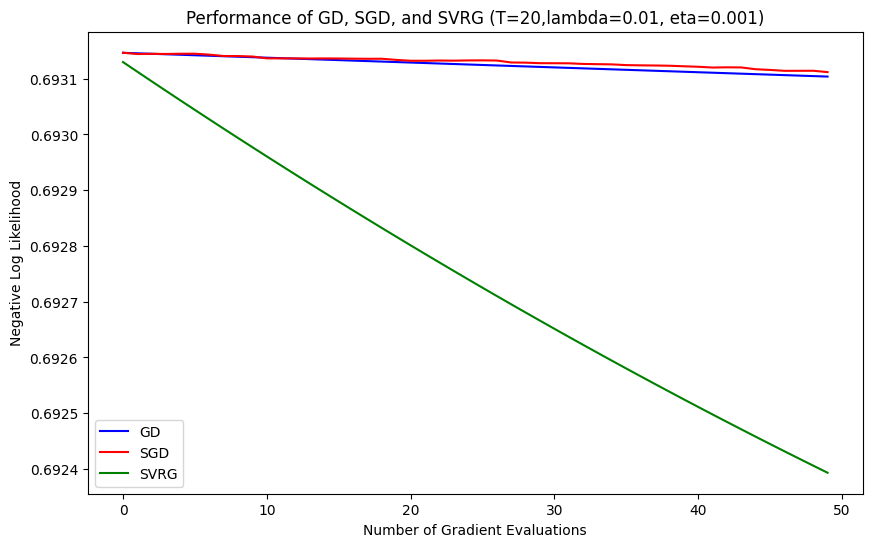

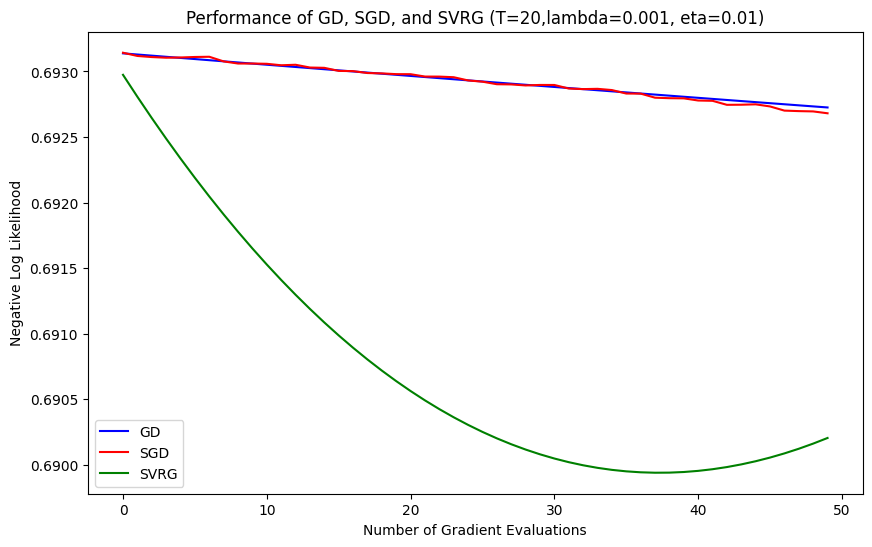

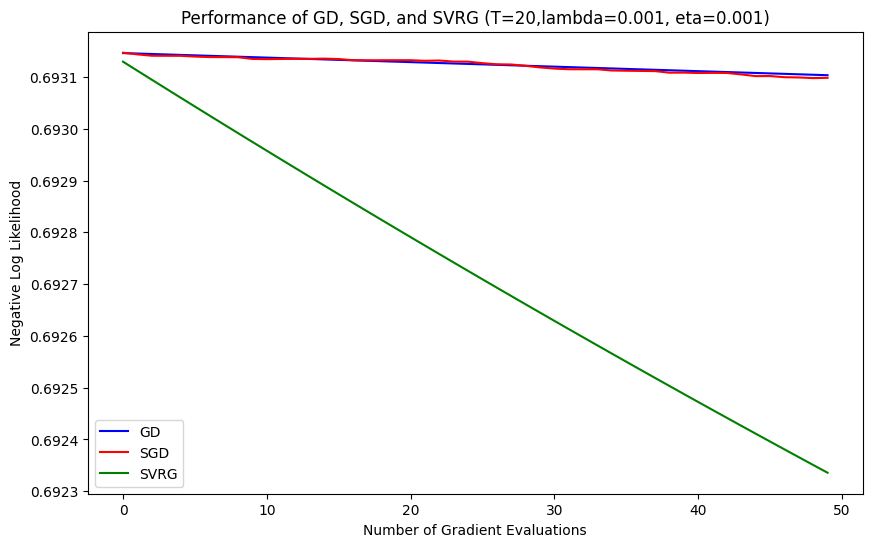

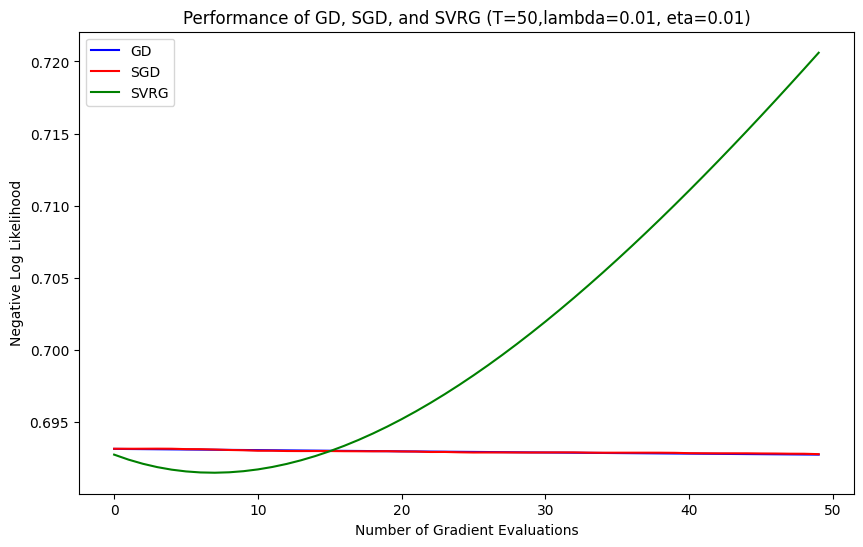

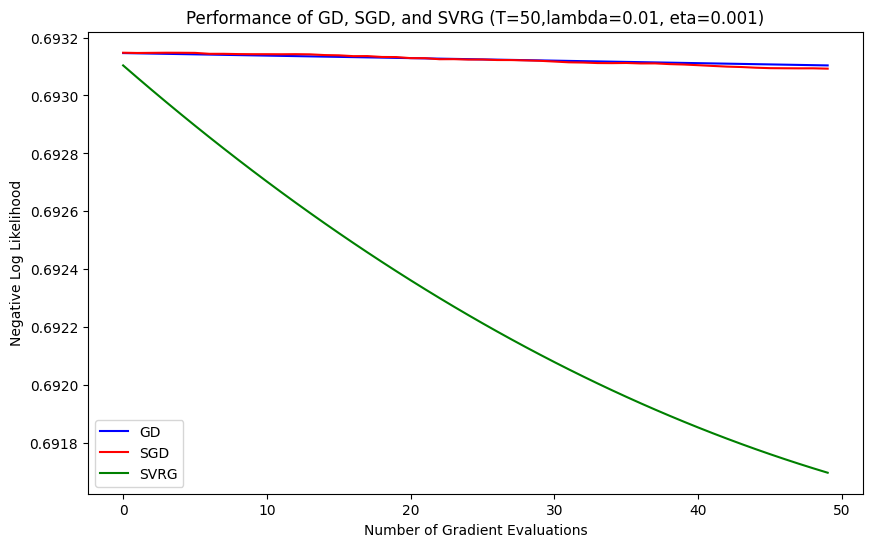

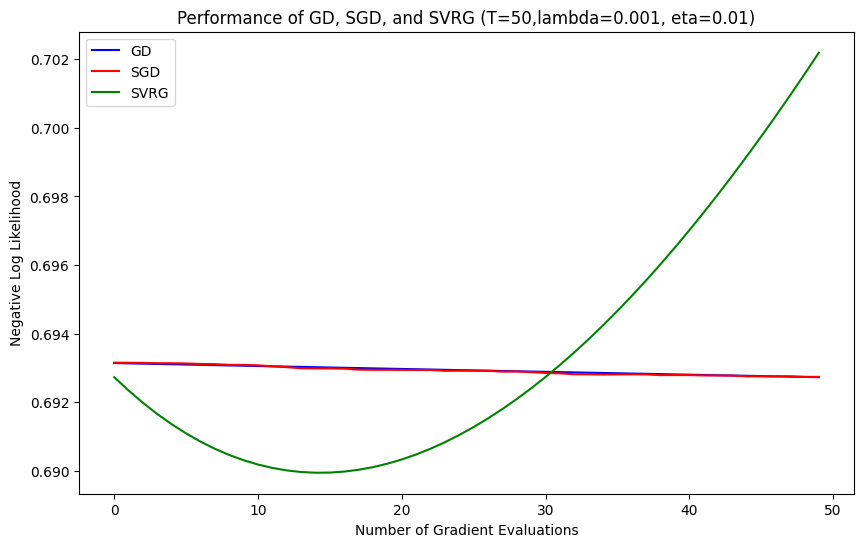

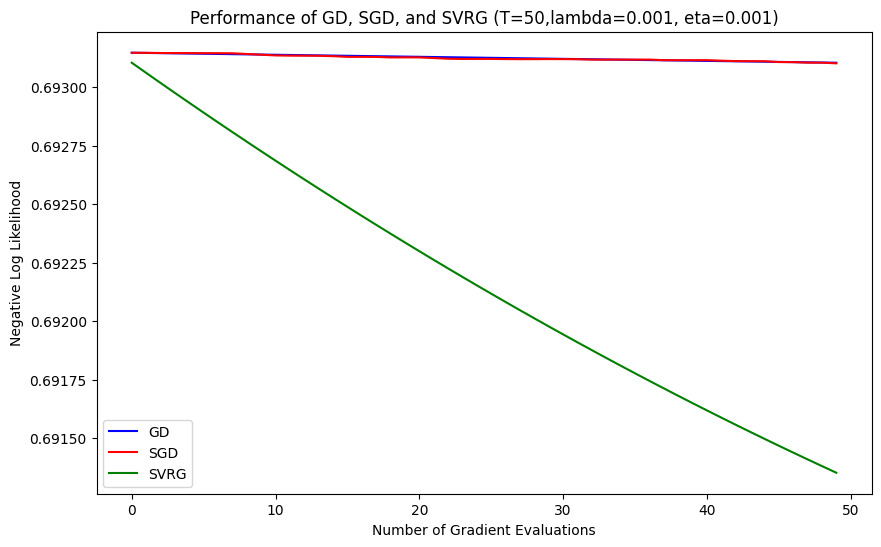

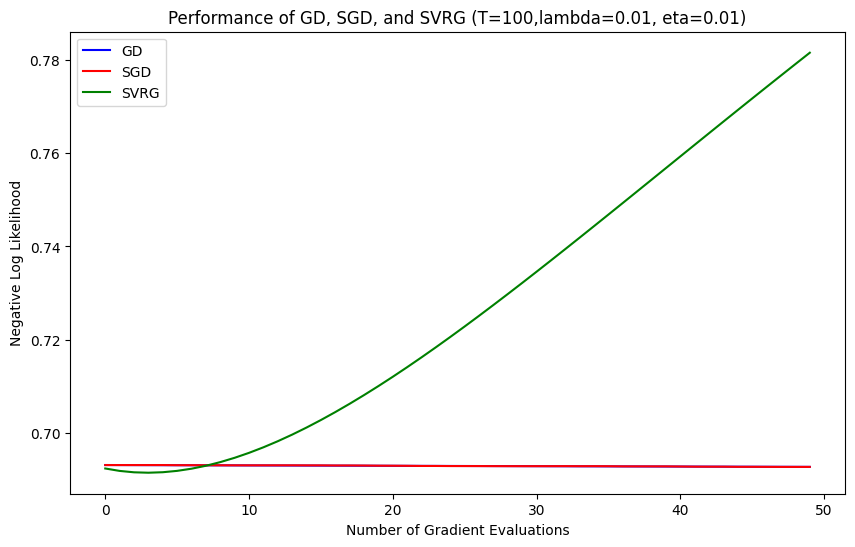

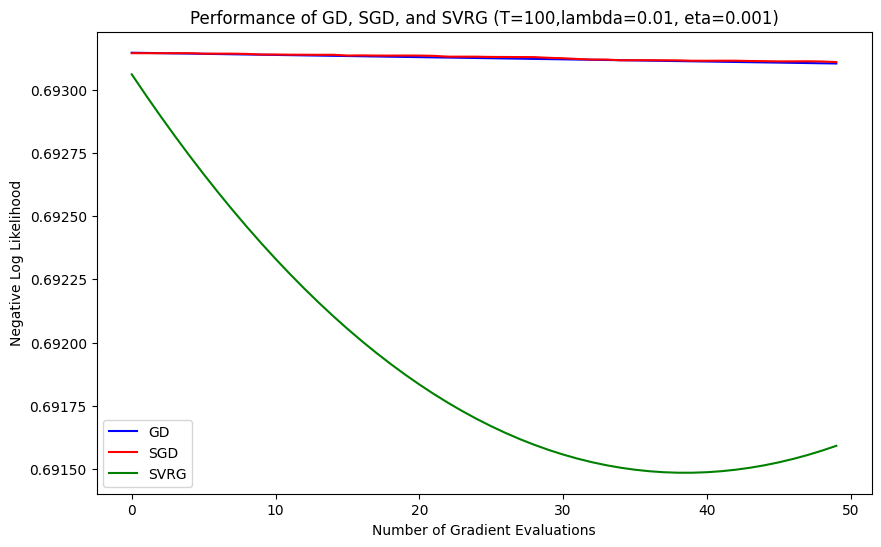

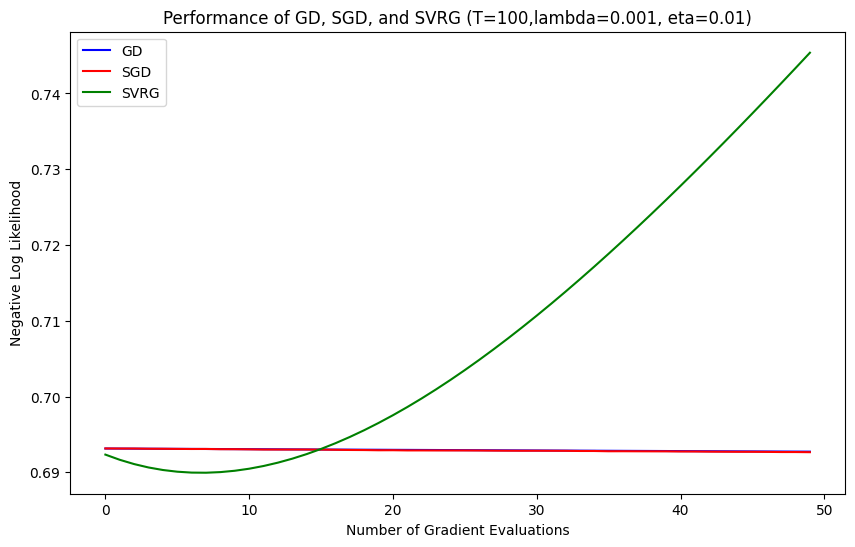

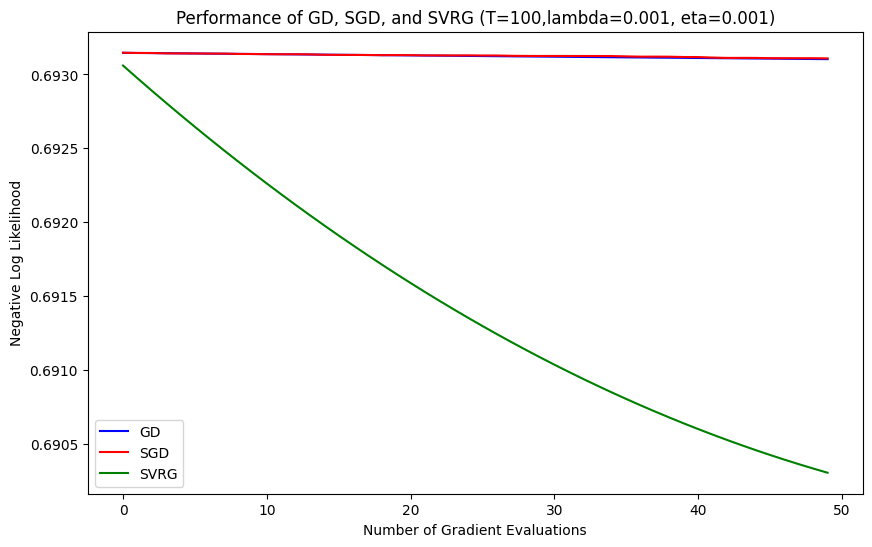

In [ ]:
# Logistic regression with L2 regularization
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def logistic_loss(y, x, w, lam):
    z = np.dot(x, w)
    loss = np.mean(np.log(1 + np.exp(-y * z))) + (lam / 2) * np.sum(w ** 2)
    return loss

def logistic_grad(y, x, w, lam):
    z = np.dot(x, w)
    grad = -np.dot(x.T, (y - sigmoid(z))) / len(y) + lam * w
    return grad

# Gradient Descent
def GD(X, y, lam, eta, epochs=100):
    w = np.zeros(X.shape[1])
    losses = []
    for epoch in range(epochs):
        grad = logistic_grad(y, X, w, lam)
        w -= eta * grad
        loss = logistic_loss(y, X, w, lam)
        losses.append(loss)
    return w, losses

# Stochastic Gradient Descent
def SGD(X, y, lam, eta, epochs=100):
    w = np.zeros(X.shape[1])
    losses = []
    for epoch in range(epochs):
        idx = np.random.randint(0, len(y))
        grad = logistic_grad(y[idx:idx+1], X[idx:idx+1], w, lam)
        w -= eta * grad
        loss = logistic_loss(y, X, w, lam)
        losses.append(loss)
    return w, losses

# Stochastic Variance Reduced Gradient Descent
def SVRG(X, y, lam, eta, epochs, m):
    n, d = X.shape
    w = np.zeros(d)
    w_tilde = np.zeros(d)
    losses = []
    for epoch in range(epochs):
        w_tilde = np.copy(w)
        mu = logistic_grad(y, X, w_tilde, lam)
        for i in range(m):
            idx = np.random.randint(0, n)
            grad_i = logistic_grad(y[idx:idx+1], X[idx:idx+1], w, lam)
            grad_tilde_i = logistic_grad(y[idx:idx+1], X[idx:idx+1], w_tilde, lam)
            w -= eta * (grad_i - grad_tilde_i + mu)
        loss = logistic_loss(y, X, w, lam)
        losses.append(loss)
    return w, losses



# L2 parameter - will create a list of values and plot the combination between lambda and T to figure out what
# is the impact they have on each other

lambdas = [0.01, 0.001]
Ts = [5, 10, 20, 50, 100]
etas = [0.01, 0.001]
#to store the values
performance_metrics = []

# Convert the multi-class labels into binary labels
# Even digits will be -1, odd digits will be 1
y_digits_train_binary = np.where(y_digits_train % 2 == 0, -1, 1)
y_digits_test_binary = np.where(y_digits_test % 2 == 0, -1, 1)


X_digits_train /= 16

for T in Ts:
    for lam in lambdas:
      for eta in etas:
        # Train models
        w_gd, losses_gd = GD(X_digits_train, y_digits_train_binary, lam=lam, eta=eta, epochs=50)
        w_sgd, losses_sgd = SGD(X_digits_train, y_digits_train_binary, lam=lam, eta=eta, epochs=50)
        w_svrg, losses_svrg = SVRG(X_digits_train, y_digits_train_binary, lam=lam, eta=eta, epochs=50, m=T)

        # Store performance metrics
        performance_metrics.append({
            'lambda': lam,
            'T': T,
            'eta': eta,
            'losses_gd': losses_gd,
            'losses_sgd': losses_sgd,
            'losses_svrg': losses_svrg
        })


# Plotting performance for each combination
for metrics in performance_metrics:
    plt.figure(figsize=(10, 6))
    plt.plot(metrics['losses_gd'], label='GD', color='blue')
    plt.plot(metrics['losses_sgd'], label='SGD', color='red')
    plt.plot(metrics['losses_svrg'], label='SVRG', color='green')
    plt.xlabel('Number of Gradient Evaluations')
    plt.ylabel('Negative Log Likelihood')
    title = f'Performance of GD, SGD, and SVRG (T={metrics["T"]},lambda={metrics["lambda"]}, eta={metrics["eta"]})'
    plt.title(title)
    plt.legend()
    plt.show()

The choice of T (the number of inner loop iterations in SVRG), and Lambda (the regularization parameter) is crucial for the algorithm's performance. Here's how it can affect the learning process:

Convergence Rate: T determines how often the full gradient is computed, which is used to reduce the variance of the stochastic gradients. If T is too small, you may compute the full gradient too often, which can be computationally expensive and may not give the stochastic gradients enough time to benefit from the variance reduction. If
T is too large, the full gradient calculation becomes infrequent.

It was noted that values of lambda too high (0.01) led to divergence. Few reasons may be:
- Over-Regularization: A large λ heavily penalizes the model's complexity, which can be beneficial for preventing overfitting but can also lead to underfitting. In the case of underfitting, the model is too simple to capture the underlying pattern in the data, resulting in poor training performance and potentially divergence if the regularization term dominates the loss function.
- Gradient Dominance: With a large λ, the regularization gradient (which is λ times w) can dominate the loss gradient.
- Learning Rate Interaction: A higher λ can interact with the learning rate in such a way that the effective updates are too large, causing the parameters to overshoot the minimum of the loss function. If the learning rate is not adjusted to account for the larger gradients due to a high
λ, divergence can occur (a higher lambda might require a smaller learning rate).

It was also noted divergence when T was high with a learning rate of 0.01. If the learning rate is too high, the SRVG algorithm may take too large steps and overshoot to the minimum and diverge.
A good combination was learning rate as 0.001, lambda as 0.001, and 50 iterations.


# Problem 2: Newsgroup Dataset Optimization

Using any approach, optimize performance of logistic regression on the test set in **news.zip** and compare the performance of your approach to standard SGD. This dataset is the full-dimensional newsgroup dataset (as opposed to the compressed version you worked with previously). The $X$ matrices are stored in sparse matrix format and can be read using scipy.io.mmread. As the dataset is large and high-dimensional, you will have to decide on how best to allocate your computational resources. Try to utilize the sparsity of the data (i.e., don't just convert it to a dense matrix and spend all your time multiplying zeros). You may use any of the techniques covered in class or ideas from outside class (e.g., momentum, variance reduction, minibatches, adaptive learning rates, preprocessing). Describe your methodology and comment on what you found improved performance and why. Plot the performance (negative log likelihood) of your method against standard SGD in terms of the number of gradient evaluations.

Will try the following to improve the performance:
- Pre-processing: to reduce dimensionality
- Optimizer: will use SVRG to try to speed up convergence.
- Use of Mini-batching
- Use of diminishing learning rate


dict_keys(['X_news_test.mtx', 'X_news_train.mtx', 'y_news_test.csv', 'y_news_train.csv'])


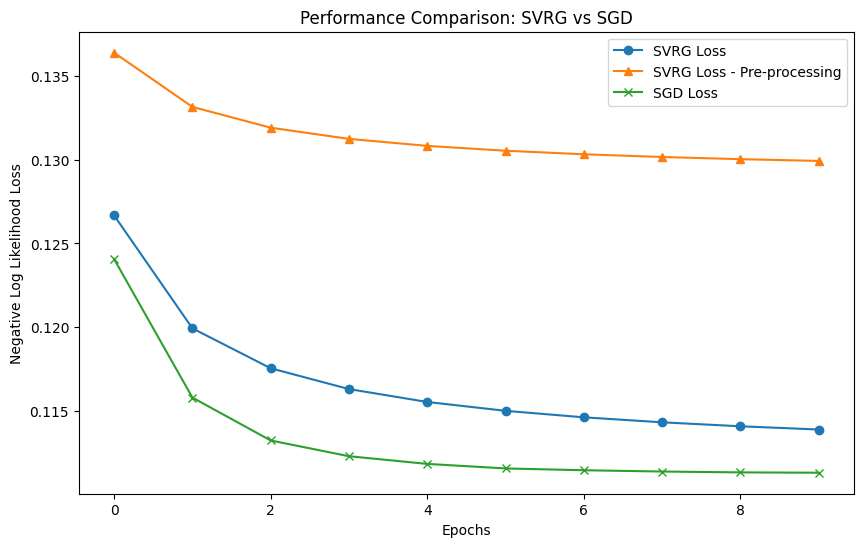

In [ ]:
from scipy.io import mmread
from scipy.sparse import csr_matrix
from sklearn.linear_model import SGDClassifier
#from sklearn.preprocessing import StandardScaler
#from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import pandas as pd


#sample code to load news.zip
def loadnewsdata(filename='./news.zip'):
    data={}
    with zipfile.ZipFile(filename) as z:
        for filename in z.namelist():
          if 'csv' in filename:
            data[filename] = pd.read_csv(z.open(filename), sep=' ', header=None)
          elif 'mtx' in filename:
            data[filename] = mmread(z.open(filename))
          else:
            raise Exception('unexpected filetype')
    return data

news_dict = loadnewsdata('./news.zip')
print(news_dict.keys())
X_news_train = news_dict['X_news_train.mtx']
X_news_test = news_dict['X_news_test.mtx']
y_news_train = news_dict['y_news_train.csv'].to_numpy(dtype=int).ravel()
y_news_test = news_dict['y_news_test.csv'].to_numpy(dtype=int).ravel()

def logistic_loss_and_gradient(w, X, y, alpha):
  m = X.shape[0]
  z = X.dot(w)
  # Logistic loss
  loss = np.mean(np.log(1 + np.exp(-y*z))) + (alpha / 2) * np.sum(w * w)
  # Gradient of the loss
  grad = -(X.T.dot(y * (1 - 1 / (1 + np.exp(-y*z)))) / m) + alpha * w
  return loss, grad

#from previous exercise - adapted
def svrg(X_train, y_train, alpha, n_epochs, batch_size, initial_step_size):
  n, d = X_train.shape
  w = np.zeros(d)
  losses = []

  for epoch in range(n_epochs):
    step_size = initial_step_size / (1 + epoch)
    full_grad = logistic_loss_and_gradient(w, X_train, y_train, alpha)[1]
    w_tilde = np.copy(w)

    for _ in range(n // batch_size):
      idx = np.random.choice(n, batch_size, replace=False)
      X_batch, y_batch = X_train[idx], y_train[idx]
      batch_grad = logistic_loss_and_gradient(w, X_batch, y_batch, alpha)[1]
      w_tilde_grad = logistic_loss_and_gradient(w_tilde, X_batch, y_batch, alpha)[1]
      w -= step_size * (batch_grad - w_tilde_grad + full_grad)

    # Calculate and store the loss
    loss = logistic_loss_and_gradient(w, X_train, y_train, alpha)[0]
    losses.append(loss)

  return w, losses

def sgd(X_train, y_train, alpha, n_epochs, batch_size, step_size):
  n, d = X_train.shape
  w = np.zeros(d)
  losses = []

  for epoch in range(n_epochs):
    for _ in range(n // batch_size):
      idx = np.random.choice(n, batch_size, replace=False)
      X_batch, y_batch = X_train[idx], y_train[idx]
      loss, grad = logistic_loss_and_gradient(w, X_batch, y_batch, alpha)
      w -= step_size * grad

    # Calculate and store the loss for the entire dataset
    epoch_loss = logistic_loss_and_gradient(w, X_train, y_train, alpha)[0]
    losses.append(epoch_loss)

  return w, losses

# Parameters
alpha = 0.01  # L2 regularization strength
n_epochs = 10  # Number of epochs - will start using epochs as variable name instead of T
batch_size = 100  # size of each mini-batch for stochastic updates
initial_lr = 0.1  # intial step size

# Convert to CSR format for efficient row slicing
X_train_csr = csr_matrix(X_news_train)
y_train = y_news_train


#pre processing - will give it a try to see if it improves
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MaxAbsScaler
from sklearn.decomposition import TruncatedSVD

# 1. Variance thresholding
selector = VarianceThreshold(threshold=(.01 * (1 - .01)))
X_train_var = selector.fit_transform(X_train_csr)

# 2. Dimensionality reduction
svd = TruncatedSVD(n_components=6)
X_train_svd = svd.fit_transform(X_train_var)

# 3. Feature scaling
scaler = MaxAbsScaler()
X_train_scaled = scaler.fit_transform(X_train_svd)


# call svrg
w_svrg, losses_svrg = svrg(X_train_csr, y_train, alpha, n_epochs, batch_size, initial_lr)

# call svrg with pre-processed train data
w_svrg_trained, losses_svrg_trained = svrg(X_train_scaled, y_train, alpha, n_epochs, batch_size, initial_lr)

# call sgd
w_sgd, losses_sgd = sgd(X_train_csr, y_train, alpha, n_epochs, batch_size, initial_lr)

# Plotting the performance comparison
plt.figure(figsize=(10, 6))
plt.plot(losses_svrg, label='SVRG Loss', marker='o')
plt.plot(losses_svrg_trained, label='SVRG Loss - Pre-processing', marker='^')
plt.plot(losses_sgd, label='SGD Loss', marker='x')
plt.xlabel('Epochs')
plt.ylabel('Negative Log Likelihood Loss')
plt.title('Performance Comparison: SVRG vs SGD')
plt.legend()
plt.show()



Explanation:
X-axis (T): number of iterations.

Y-axis (Negative Log Likelihood Loss): Represents the negative log likelihood loss, a measure of how well the model fits the data. Lower values are better, indicating that the model's predictions are closer to the true labels.

SVRG Loss (Blue Line): Shows how the loss for the SVRG method decreases as more iterations are completed. The SVRG method starts with a higher loss but decreases rapidly, indicating effective learning and improvement in model performance per epoch.

SVRG Loss - Pre processing (Orange Line): The plot suggests that pre-processing did not significantly improve the performance of SVRG. This could be because the pre-processing steps either removed too much information or did not align well with the logistic regression model's needs.
SGD Loss With Mini Batches (Green Line): Shows how the loss for the SGD method using mini batches changes across epochs. This line also shows a rapid decrease but appears to level off, indicating that the model is converging towards a minimum loss.

Comparison: By comparing the two lines, you can assess which method is reducing the loss more effectively over time. In this case, SVRG starts with a higher loss but overtakes the SGD with mini batches, suggesting it might be converging faster after the initial epochs.

Convergence Rate: The slope of the loss lines gives an idea of the convergence rate. A steeper slope indicates faster convergence. SVRG's steeper slope compared to SGD with mini batches suggests it is converging faster after the initial iterations.

Performance: The final points on the plot show the loss values at the end of training.

Overall, the plot suggests that SVRG, after some initial adjustment, potentially provides a better convergence rate and may lead to a lower loss compared to SGD with mini batches, at least over the number of epochs shown